In [2]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from coffea import hist
from coffea.processor import defaultdict_accumulator

import optparse
import importlib
import pathlib

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.CMS)
#hep.CMS.text("Phase 2 Simulation")

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

In [3]:
model_id_name = '../../models/Feb_4_2023_JetMetTalk_v1_SigPtTruth20.h5'
model_pt_regress_name = '../models/pt_regress_v1.h5'

In [4]:
test_index = 400000

In [5]:
MinBias = uproot4.open("../../ntuples/Jan_25_2023/test_bkg_v12_emseed.root")
MinBias_id = np.asarray(MinBias['ntuplePupSingle']['tree']['event'].array())[test_index:]
MinBias_iso = np.asarray(MinBias['ntuplePupSingle']['tree']['chargedIso'].array())[test_index:]
MinBias_pt = np.asarray(MinBias['ntuplePupSingle']['tree']['pt'].array())[test_index:]
MinBias_inputs = np.nan_to_num(np.asarray(MinBias['ntuplePupSingle']['tree']['m_inputs'].array())[test_index:])

n_event = np.unique(MinBias_id).shape[0]

In [6]:
model_id = load_model(model_id_name)
MinBias_nn_score_model = model_id.predict(MinBias_inputs)

model_regress = load_model(model_pt_regress_name)
MinBias_nn_selected_pt_ratio = model_regress.predict(MinBias_inputs).flatten()

2023-06-26 09:24:56.432965: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-26 09:24:56.432999: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-26 09:24:56.433025: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (submit03.mit.edu): /proc/driver/nvidia/version does not exist
2023-06-26 09:24:56.433404: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


8869/8869 [==============================] - 13s 1ms/step


In [7]:
MinBias_pt_corrected = np.multiply(MinBias_nn_selected_pt_ratio, MinBias_pt)

In [8]:
nn_cut = 0.28 #official NN cut point

In [9]:
MinBias_nn_selected_id = MinBias_id[MinBias_nn_score_model.flatten() > nn_cut]
MinBias_nn_selected_pt = MinBias_pt[MinBias_nn_score_model.flatten() > nn_cut]
MinBias_nn_selected_pt_corrected = MinBias_pt_corrected[MinBias_nn_score_model.flatten() > nn_cut]

In [10]:
minbias_rate_nn = []
minbias_rate_nn_corrected = []

pt_cuts = list(np.arange(0,250,10))

for pt_cut in pt_cuts:
    
    print("pT Cut: ", pt_cut)
    n_pass_nn = np.unique(MinBias_nn_selected_id[MinBias_nn_selected_pt > pt_cut]).shape[0]
    n_pass_nn_corrected = np.unique(MinBias_nn_selected_id[MinBias_nn_selected_pt_corrected > pt_cut]).shape[0]
    print("Ratio (NN): ", n_pass_nn/n_event)
    print('------------')
    
    minbias_rate_nn.append((n_pass_nn/n_event)*32e+3) #Convert to kHz (multiply by 32e+6)
    minbias_rate_nn_corrected.append((n_pass_nn_corrected/n_event)*32e+3)


pT Cut:  0
Ratio (NN):  0.27470276159348206
------------
pT Cut:  10
Ratio (NN):  0.2584197811567429
------------
pT Cut:  20
Ratio (NN):  0.04423049594997868
------------
pT Cut:  30
Ratio (NN):  0.014546129190153632
------------
pT Cut:  40
Ratio (NN):  0.006240822320117474
------------
pT Cut:  50
Ratio (NN):  0.002996068400360002
------------
pT Cut:  60
Ratio (NN):  0.0016302717382723068
------------
pT Cut:  70
Ratio (NN):  0.0008368465097184722
------------
pT Cut:  80
Ratio (NN):  0.0004697393144174443
------------
pT Cut:  90
Ratio (NN):  0.0003118437465460344
------------
pT Cut:  100
Ratio (NN):  0.00017368512465855084
------------
pT Cut:  110
Ratio (NN):  0.00010657950831320165
------------
pT Cut:  120
Ratio (NN):  6.315822714856394e-05
------------
pT Cut:  130
Ratio (NN):  3.9473891967852463e-05
------------
pT Cut:  140
Ratio (NN):  3.5526502771067216e-05
------------
pT Cut:  150
Ratio (NN):  2.7631724377496724e-05
------------
pT Cut:  160
Ratio (NN):  1.973694598392

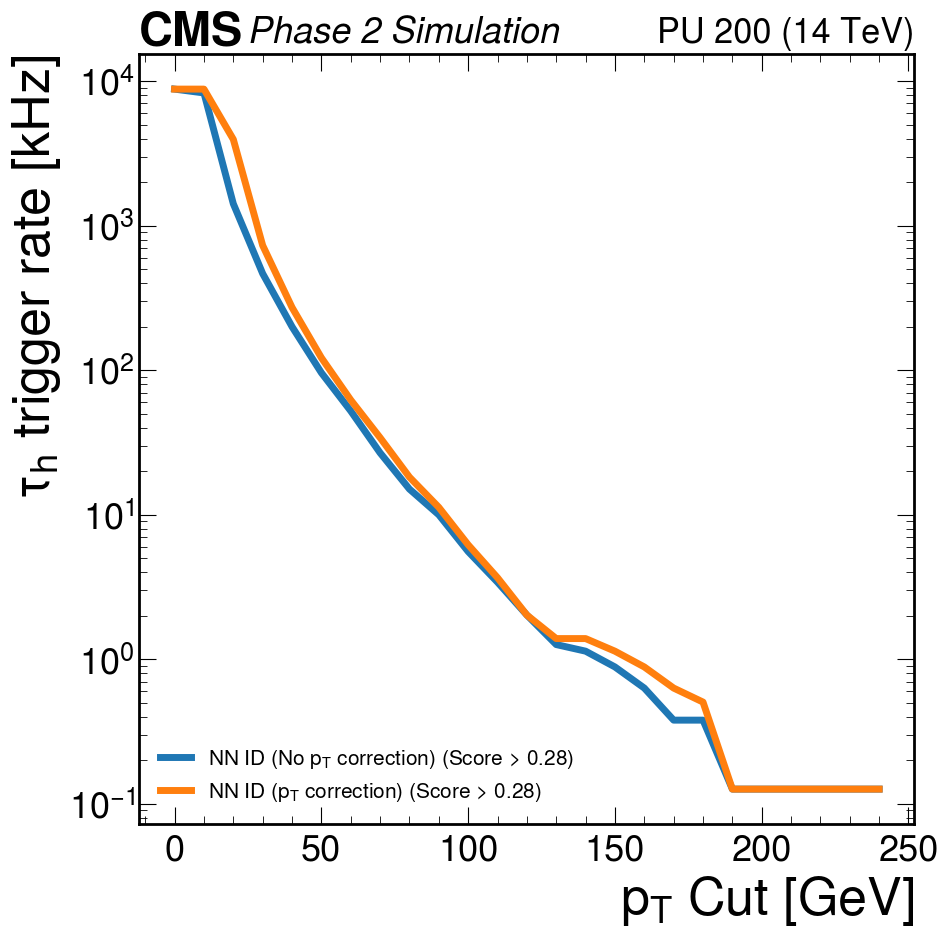

In [11]:
plt.plot(pt_cuts, minbias_rate_nn, label = r"NN ID (No $p_T$ correction) (Score > {})".format(nn_cut), linewidth=5)
plt.plot(pt_cuts, minbias_rate_nn_corrected, label = r"NN ID ($p_T$ correction) (Score > {})".format(nn_cut), linewidth=5)

hep.cms.text("Phase 2 Simulation")
hep.cms.lumitext("PU 200 (14 TeV)")
plt.yscale('log')
plt.ylabel(r"$\tau_h$ trigger rate [kHz]")
plt.xlabel(r"$p_T$ Cut [GeV]")
plt.legend(loc = 'lower left',fontsize = 15)
plt.show()

-----

# ROC Curve Rate Plot

In [12]:
truth_sig_pt_cut = 20.

#Filter out the test signals
sig = uproot4.open("../../ntuples/Jan_25_2023/test_sig_v12_emseed.root")
bkg = uproot4.open("../../ntuples/Jan_25_2023/test_bkg_v12_emseed.root")

unique_bkg_event = np.unique(np.asarray(bkg['ntuplePupSingle']['tree']['event'].array()))
unique_sig_event = np.unique(np.asarray(sig['ntuplePupSingle']['tree']['event'].array())[test_index:])

#Load model and select out the tau
model = load_model(model_id_name)

#Sig
sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]

truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[test_index:]
truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]
selection_sig = (truth_pt_sig > truth_sig_pt_cut) & (abs(truth_deltaR_sig) < 0.4) &(abs(truth_eta_sig) < 2.4)

sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[test_index:][selection_sig])

X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig]))
X_sig[abs(X_sig) > 1e+4] = 0.

#
y_sig = model.predict(X_sig)

#Bkg
bkg_input = np.asarray(bkg['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:])
bkg_id = np.asarray(bkg['ntuplePupSingle']['tree']['event'].array()[test_index:])
bkg_pt = np.asarray(bkg['ntuplePupSingle']['tree']['pt'].array()[test_index:])


selection_bkg = bkg_pt > 20
bkg_id_pt = bkg_id[selection_bkg]

total_n_minbias = np.unique(bkg_id).shape[0]
total_n_sig = np.intersect1d(np.unique(bkg_id), np.unique(sig_id)).shape[0]

bkg_input[abs(bkg_input) > 1e+4] = 0.
y_bkg = model.predict(bkg_input[selection_bkg])

868/868 [==============================] - 1s 1ms/step


In [13]:
bkg_pass_corrected_ratio = model_regress.predict(bkg_input).flatten()
bkg_pt_corrected = np.multiply(bkg_pt, bkg_pass_corrected_ratio)

selection_bkg_corrected = bkg_pt_corrected > 20. 

bkg_id_pt_corrected = bkg_id[selection_bkg_corrected]
y_bkg_corrected = model.predict(bkg_input[selection_bkg_corrected]).flatten()

1805/1805 [==============================] - 2s 1ms/step


In [14]:
tau_score_edges = [round(i,2) for i in np.arange(0, 0.9, 0.01).tolist()]+\
                  [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

sig_list = []
bkg_list = []

for tau_score_cut in tau_score_edges:
    
    bkg_pass = np.unique(bkg_id_pt[y_bkg.flatten() > tau_score_cut]).shape[0]
    sig_pass = np.unique(sig_id[y_sig.flatten() > tau_score_cut])

    real_sig_pass = np.intersect1d(np.unique(bkg_id),sig_pass).shape[0]
    
    sig_list.append(real_sig_pass/total_n_sig)
    bkg_list.append(bkg_pass/total_n_minbias)

    

bkg_list_scaled = [i*(32e+3) for i in bkg_list]

In [15]:
tau_score_edges = [round(i,2) for i in np.arange(0, 0.9, 0.01).tolist()]+\
                  [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

sig_list_corrected = []
bkg_list_corrected = []

for tau_score_cut in tau_score_edges:
    
    bkg_pass = np.unique(bkg_id_pt_corrected[y_bkg_corrected > tau_score_cut]).shape[0]
    sig_pass = np.unique(sig_id[y_sig.flatten() > tau_score_cut])

    real_sig_pass = np.intersect1d(np.unique(bkg_id),sig_pass).shape[0]
    
    sig_list_corrected.append(real_sig_pass/total_n_sig)
    bkg_list_corrected.append(bkg_pass/total_n_minbias)

bkg_list_corrected_scaled = [i*(32e+3) for i in bkg_list_corrected]

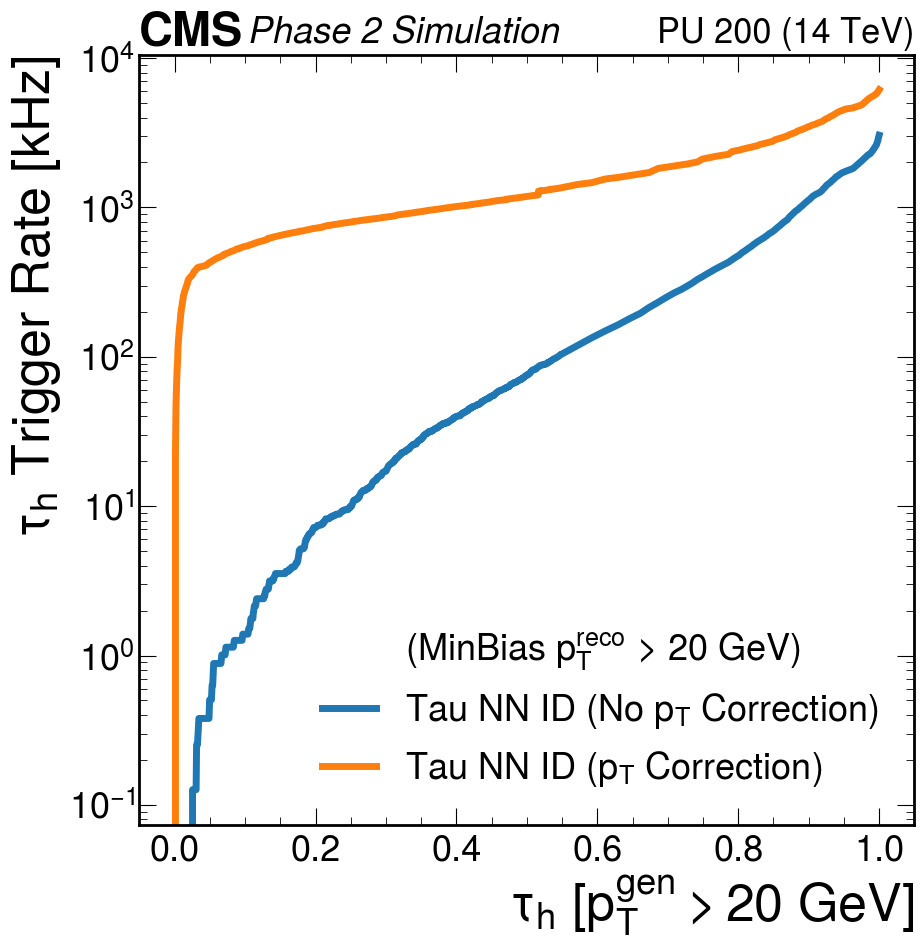

In [16]:
plt.plot([],[], 'none', label=r'(MinBias $p_T^{reco}$ > 20 GeV)')
plt.plot(sig_list, bkg_list_scaled, label=r'Tau NN ID (No $p_T$ Correction)',linewidth=5)
plt.plot(sig_list_corrected, bkg_list_corrected_scaled, label=r'Tau NN ID ($p_T$ Correction)',linewidth=5)
hep.cms.text("Phase 2 Simulation")
hep.cms.lumitext("PU 200 (14 TeV)")

plt.ylabel(r'$\tau_h$ Trigger Rate [kHz]')
plt.xlabel(r'$\tau_h$ [$p_T^{gen} > % d$ GeV]' %int(truth_sig_pt_cut))

plt.yscale('log')
plt.legend()

### Other ROC Curve Plot

In [17]:
NormalModel = load_model('../../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5')
    
y_pred_mono = model(X_test)
fpr_mono, tpr_mono, _ = roc_curve(y_test, y_pred_mono.detach().numpy())
auc_score_mono = round(auc(fpr_mono, tpr_mono),2)

y_pred_normal = NormalModel.predict(X_test.detach().numpy())
fpr_normal, tpr_normal, _ = roc_curve(y_test,y_pred_normal)
auc_score_normal = round(auc(fpr_normal, tpr_normal),2)

NameError: name 'X_test' is not defined

In [ ]:
#Create plot for ROC
plt.figure(1)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_mono, tpr_mono, label = 'Tau NN Mono, AUC: {}'.format(auc_score_mono))
plt.plot(fpr_normal, tpr_normal, label = 'Normal Tau NN, AUC: {}'.format(auc_score_normal))

#Establish labels and save image
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show()